# Current Problem Statement
I am on a gameshow, and the host has an unknown $\vec{x}$. I am trying to uncover that $\vec{x}$. He samples one row $
\vec{w_1}^T=[w_{11}, w_{12}, ..., w_{1n}]$ from the Walsh matrix without replacement and multiplies it with that $\vec{x}$ to get $\vec{y_1}$, which is now a scalar, since he sampled one row. I try to find all $\tilde{x}$ such that $\vec{w_1}\tilde{x}=\vec{y_1}$ is satisfied. I must end up with at most $_{n}C_{k}$ $\tilde{x}$'s, including one that is actually equal to $x$. I keep these all in a pool. Then, the host samples another row, forming the matrix: 

$\hat{W}=\begin{bmatrix}
\vec{w_1}^T \\
\vec{w_2}^T
\end{bmatrix}$

Select the $\tilde{x}$'s from the set we have that are consistent with $\hat{W}{\vec{x}}={\vec{y_2}}$. We should have less than $_{n}C_{k}$ solutions. However, once the host samples $\frac{klog_{2}(N)}{log_{2}(K)}$ rows, we should only have one unique solution, which is the correct $x$. If we don't, this is an unsuccessful run.

Later, develop a deep policy/reinforcement learning network that can cleverly sample rows of the Walsh matrix such that $x$ is uncovered at the optimal time.


# Naive Solution
Below, we check every possible solution to $\hat{W}{\vec{x}}={\vec{y}}$ on each iteration. The computation explodes at around $K=16$.

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial, ceil
from tqdm.auto import trange, tqdm

Number of possible x vectors: 12


  0%|          | 0/50 [00:00<?, ?it/s]

x = [1. 0. 0. 1.]
y_2 = [2. 1.]
y_3 = [2. 1. 2.]
y_4 = [2. 1. 2. 1.]
x = [0. 1. 1. 0.]
y_2 = [1. 0.]
y_3 = [1. 0. 2.]
y_4 = [1. 0. 2. 1.]
x = [1. 1. 0. 0.]
y_2 = [2. 1.]
y_3 = [2. 1. 2.]
y_4 = [2. 1. 2. 1.]
x = [1. 0. 1. 0.]
y_2 = [2. 2.]
y_3 = [2. 2. 1.]
y_4 = [2. 2. 1. 1.]
x = [0. 1. 1. 0.]
y_2 = [0. 2.]
y_3 = [0. 2. 1.]
y_4 = [0. 2. 1. 1.]
x = [1. 0. 1. 0.]
y_2 = [2. 2.]
y_3 = [2. 2. 1.]
y_4 = [2. 2. 1. 1.]
x = [1. 0. 0. 1.]
y_2 = [2. 2.]
y_3 = [2. 2. 1.]
y_4 = [2. 2. 1. 1.]
x = [0. 1. 0. 1.]
y_2 = [1. 1.]
y_3 = [1. 1. 2.]
y_4 = [1. 1. 2. 0.]
x = [1. 1. 0. 0.]
y_2 = [1. 2.]
y_3 = [1. 2. 2.]
y_4 = [1. 2. 2. 1.]
x = [0. 0. 1. 1.]
y_2 = [0. 1.]
y_3 = [0. 1. 2.]
y_4 = [0. 1. 2. 1.]
x = [1. 1. 0. 0.]
y_2 = [1. 2.]
y_3 = [1. 2. 1.]
y_4 = [1. 2. 1. 2.]
x = [0. 0. 1. 1.]
y_2 = [2. 1.]
y_3 = [2. 1. 0.]
y_4 = [2. 1. 0. 1.]
x = [1. 1. 0. 0.]
y_2 = [2. 2.]
y_3 = [2. 2. 1.]
y_4 = [2. 2. 1. 1.]
x = [1. 0. 1. 0.]
y_2 = [1. 2.]
y_3 = [1. 2. 1.]
y_4 = [1. 2. 1. 2.]
x = [0. 0. 1. 1.]
y_2 = [1. 0.]
y_

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


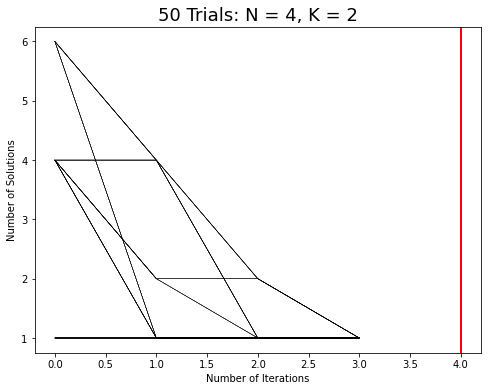

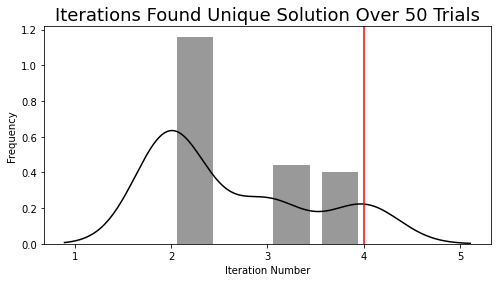

In [72]:
# Helper Functions
def to_binary(n, N):
    """
    Get binary representation of input n

    :param n: Integer of which to get binary representation
    :param N: Length of bitstring
    :return: str
    """
    return bin(n).replace('0b', '').zfill(N)


def get_w_hat_t_helper(row_idx, col_idx, N):
    """
    Helper function to get entry (t, col_idx) of W-H matrix

    :param row_idx: Row index of W-H matrix to find
    :param col_idx: Column index of W-H matrix to find
    :param N: Order of W-H matrix
    :return: int
    """
    row_bin = to_binary(row_idx, N)
    col_bin = to_binary(col_idx, N)

    row_list = [int(row_bit) for row_bit in list(row_bin[::-1])]
    col_list = [int(col_bit) for col_bit in list(col_bin[::-1])]

    result = 0
    for row_bit, col_bit in zip(row_list, col_list):
        result += row_bit * col_bit

    result = int((1 + ((-1) ** result)) / 2)
    return result


def get_x_vector(N, K):
    """
    Return x from given order of WH matrix and K

    :param N: Order of WH matrix
    :param K: Number of ones
    :return: numpy.ndarray
    """
    x = np.zeros(N)
    random_pos = np.random.choice(
        np.arange(0, N), K, replace=False
    )
    x[random_pos] = 1
    return x


def get_w_hat_t(t_idx: int, N):
    """
    Get t-th row of W-H matrix of order _N

    :param t_idx: Index of row in W-H matrix
    :return: list
    """
    row = []
    for i in range(N):
        row.append(get_w_hat_t_helper(t_idx, i, N))

    return row


def get_all_1_k_vectors(N, K):
    vector = [1] * K + [0] * (N - K)
    return list(set(itertools.permutations(vector, N)))


def check_x_set(all_x, A, b):
    valid_x = set()
    for x_vector in all_x:
        if (A @ x_vector == b).all():
            valid_x.add(x_vector)

    return list(valid_x)


def recover_x_naive(N, K):
    W = np.array([get_w_hat_t(i, N) for i in range(N)])
    x = get_x_vector(N, K)
    print(f'x = {x}')

    row_pos = np.random.choice(np.arange(0, N), N, replace=False)

    # First row sampling
    W_hat = W[row_pos[0]]
    y = W_hat @ x
    all_x = get_all_1_k_vectors(N, K)
    valid_solutions = check_x_set(all_x, W_hat, y)
    num_solutions = [len(valid_solutions)]
    iteration_found = []

    for i, row_idx in enumerate(row_pos[1:]):
        # Oracle samples row
        W_hat = np.vstack((W_hat, W[row_idx]))
        y = W_hat @ x
        print(f'y_{i + 2} = {y}')
        valid_solutions = check_x_set(valid_solutions, W_hat, y)
        if len(valid_solutions) == 1:
            iteration_found.append(i + 2)
        num_solutions.append(len(valid_solutions))

    x_tilde = []
    optimum_found = N

    # If x was successfully recovered
    if len(valid_solutions) == 1:
        x_tilde = list(valid_solutions[0])
        optimum_found = iteration_found[0]

    opt = ceil(K * np.log2(N) / np.log2(K))
    plt.plot(num_solutions, lw=0.3, c='black')
    plt.ylabel('Number of Solutions')
    plt.xlabel('Number of Iterations')
    plt.axvline(opt, c='r')

    return x_tilde, optimum_found


def plot_recover_x_trials(n, N, K):
    plt.figure(figsize=(8, 6))
    n_perms = int(factorial(N) / factorial(N - K))
    print(f'Number of possible x vectors: {n_perms}')
    iteration_found = []
    for i in tqdm(range(n)):
        x, it = recover_x_naive(N, K)
        iteration_found.append(it)
    plt.title(f'{n} Trials: N = {N}, K = {K}', fontsize=18)
    plt.figure(figsize=(8, 4))
    sns.distplot(iteration_found, color='black', hist_kws={'rwidth':0.75})
    opt = ceil(K * np.log2(N) / np.log2(K))
    plt.axvline(opt, c='r')
    plt.title(f'Iterations Found Unique Solution Over {n} Trials', fontsize=18)
    plt.xlabel('Iteration Number')
    plt.ylabel('Frequency')
    print(f'Actual optimal iteration: {opt}')
    print(f'Mean optimal iteration: {np.mean(iteration_found)}')

plot_recover_x_trials(50, 4, 2)

# Faster Solution
The host gives us $\vec{y}=[y_1,...,y_{logN}]$. Let $s_1,...,s_k$ be the indices of 1 in $\vec{x}$. Given these locations, we can derive $\tilde{W}_{logN\times N}$. We multiply $\vec{x}$ by $\tilde{W}$ to get $\vec{y}$.

We want to get the $logN$ rows of the Walsh matrix that are associated with the binary expansion of each $s_i, i\in{0,...,N-1}$. This is how we derive $\tilde{W}$.

Let $\sum_{i=1}^{k}s_i=$ scalar form of $\vec{y}=\sum_{i=0}^{logN} y_i * 2^i$, from the scalar form of $\vec{y}$. We will know what all of the locations of the nonzero elements of $\vec{x}$ add up to. Thus, we receive all options for $\vec{x}$ that satisfy $W\vec{x}=\vec{y}$. This amount of solutions will be the number of ways to add up to sum of all positions of nonzero elements in $\vec{x}$.

In [73]:
N = 8
K = 3

In [117]:
def gen_W_tilde(N):
    """
    Generate W_(logN x N) with binary expansions of locations
    """
    W_tilde = np.empty((int(np.log2(N)), 0))
    for i in range(N):
        binary_str = str(to_binary(i, int(np.log2(N))))[::-1]
        list_binary_str = ([int(bit) for bit in binary_str])
        W_tilde = np.column_stack((W_tilde, list_binary_str))
    return W_tilde


def scalar(y):
    """
    Compute scalar value: Y = \sum {2^i * y_i}
    """
    print(y)
    return int(sum([2 ** i * y_i for i, y_i in enumerate(y)]))


def get_W_tilde_rows(W_tilde):
    """
    Find rows of W_tilde within the Walsh-Hadamard matrix
    """
    W_tilde_bits = [list(reversed(row)) for row in W_tilde]
    W_idx = [np.where(np.all(W == row, axis=1))[0][0] for row in W_tilde_bits]
    return W_idx


def sum_to_S(s, k, limit=None):
    """
    Helper function to return all ways for k numbers to sum up to S
    """
    if k == 1:
        yield [s]
        return
    if limit is None:
        limit = s
    start = (s + k - 1) // k
    stop = s - k + 2
    for i in range(start, stop):
        for j in sum_to_S(s - i, k - 1, i):
            yield [i] + j


def get_solutions(W_tilde, x):
    """
    
    """
    # Scalar form of y = W_tilde * x
    S = scalar(W_tilde @ x)
    print(S)
    solutions = []
    for partition in sum_to_S(S, K):
        if len(set(partition)) == len(partition):# and max(partition) < N:
            partition = sorted(partition)
            if partition not in solutions:
                solutions.append(partition)
    return solutions


def sample_remaining(W, W_tilde, x, n_rows=1):
    # Rows of W_tilde, to remove from W
    to_remove = get_W_tilde_rows(W_tilde)
    W = np.delete(W, to_remove, 0)
    initial_sols = get_solutions(W_tilde, x)
    print(f'Start with {len(initial_sols)} valid solutions')
    for i in range(n_rows):
        random_idx = np.random.choice(len(W))
        print(f'Random index: {random_idx}')
        W_tilde = np.append(W_tilde, [W[random_idx]], 0)
        W = np.delete(W, random_idx, 0)
        curr_sols = get_solutions(W_tilde, x)
        if len(curr_sols) == 1:
            print(f'Correct solution: {curr_sols[0]}')
        else:
            print(f'{len(curr_sols)} solutions left')
    
    
          

# Start with W_tilde_(logN x N), generated by agent
W_tilde = gen_W_tilde(N)
W = np.array([get_w_hat_t(i, N) for i in range(N)])
x = get_x_vector(N, K)

print(f'-----------W-Tilde-----------\n{W_tilde}\n')
print(f'-----------Walsh-Hadamard-----------\n{W}\n')
print(f'-----------x-----------\n{x}\n')
sample_remaining(W, W_tilde, x, 3)

# IDEALLY: just klogN / k + 1

-----------W-Tilde-----------
[[0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]

-----------Walsh-Hadamard-----------
[[1 1 1 1 1 1 1 1]
 [1 0 1 0 1 0 1 0]
 [1 1 0 0 1 1 0 0]
 [1 0 0 1 1 0 0 1]
 [1 1 1 1 0 0 0 0]
 [1 0 1 0 0 1 0 1]
 [1 1 0 0 0 0 1 1]
 [1 0 0 1 0 1 1 0]]

-----------x-----------
[1. 0. 0. 1. 0. 0. 1. 0.]

[1. 2. 1.]
9
Start with 3 valid solutions
Random index: 1
[1. 2. 1. 2.]
25
40 solutions left
Random index: 3
[1. 2. 1. 2. 3.]
73
408 solutions left
Random index: 1
[1. 2. 1. 2. 3. 1.]
105
867 solutions left
